In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy import io
import cvxpy as cp
import statsmodels.api as sm
import datetime as dt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import time

Symbols,MSFT,IBM,AAPL,GOOG
Date,,,,
2021-05-21,4.197860,1.062313,4.575504,2.983057
2021-05-24,4.293916,1.062166,4.636423,3.061376
2021-05-25,4.310011,1.055341,4.629128,3.064429
2021-05-26,4.306073,1.052331,4.627304,3.095543
2021-05-27,4.274824,1.056625,4.593561,3.092808


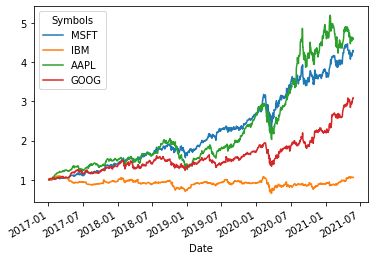

In [3]:
# load data 
stocks = DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'yahoo', start=dt.datetime(2017,1,1))['Adj Close']
# plot normalized prices of these stocks
normalized_price = stocks / stocks.iloc[0,:]
normalized_price.plot()
normalized_price.tail()
# data.shape
# stocks.plot()

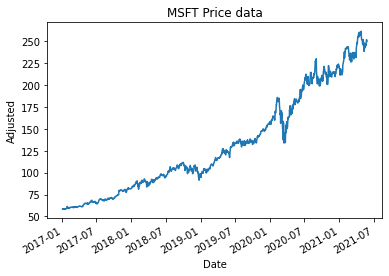

In [4]:
stocks['MSFT'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("MSFT Price data")
plt.show()

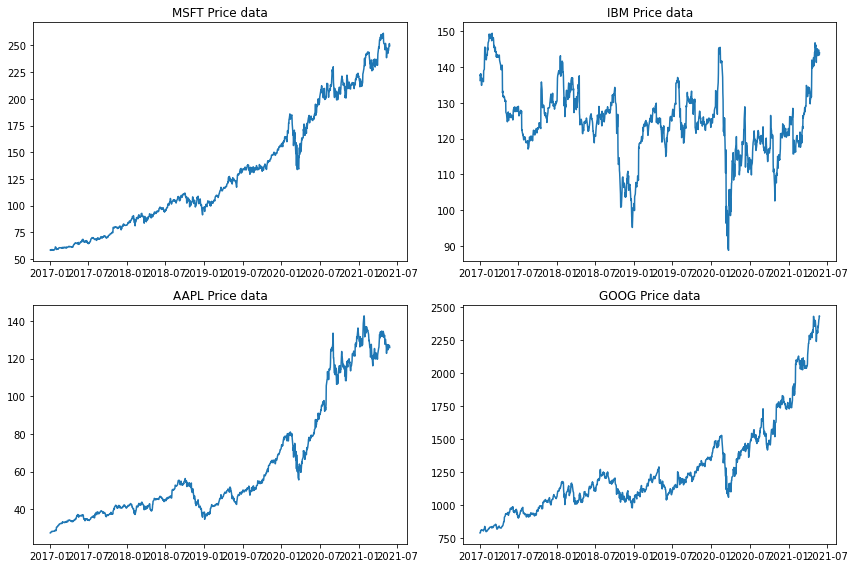

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(stocks['MSFT'])
ax1.set_title("MSFT Price data")
ax2.plot(stocks['IBM'])
ax2.set_title("IBM Price data")
ax3.plot(stocks['AAPL'])
ax3.set_title("AAPL Price data")
ax4.plot(stocks['GOOG'])
ax4.set_title("GOOG Price data")
plt.tight_layout()
plt.show()

In [6]:
MSFT_daily_returns = stocks['MSFT'].pct_change().sum()
MSFT_monthly_returns = stocks['MSFT'].resample('M').ffill().pct_change()
print(MSFT_daily_returns)

1.6315548264863535


In [7]:
stocks.describe()

Symbols,MSFT,IBM,AAPL,GOOG
count,1108.000000,1108.000000,1108.000000,1108.000000
mean,131.918992,124.917987,63.463512,1262.497403
std,57.177297,10.027998,32.049255,352.995741
min,58.142242,88.795891,27.382690,786.140015
25%,86.881145,119.760544,40.636803,1039.527527
50%,113.901039,124.861103,49.628366,1164.395020
75%,178.358974,130.010033,78.356388,1417.225006
max,261.366486,149.450806,142.704010,2433.530029


In [8]:
data = stocks/stocks.shift(1) # pt/pt-1
data = data.dropna(how='all') # delete 'NaN'
x = data.to_numpy() # relative price
#data.info()
N=x.shape[0]
d=x.shape[1]
# x=np.zeros((N,d))
b=np.ones(d)/d
x

array([[0.99552552, 1.01238108, 0.99888078, 1.00096676],
       [1.        , 0.99669153, 1.00508546, 1.00904816],
       [1.00866783, 1.00491991, 1.01114819, 1.0152767 ],
       ...,
       [1.00374832, 0.99357374, 0.99842646, 1.00099729],
       [0.9990863 , 0.9971487 , 0.99960596, 1.01015328],
       [0.9927432 , 1.00408001, 0.99270796, 0.99911645]])

In [9]:
BAH = np.dot(np.prod(data.to_numpy(), axis=0), np.ones(d)/d)

In [10]:
def opt_fractions(r):
    x = cp.Variable(d)
    constraints=[x>=0,cp.sum(x)==1]
    obj=cp.sum(cp.log(r@x))
    problem=cp.Problem(cp.Maximize(obj),constraints)
    problem.solve()
    return x.value

In [11]:
BCRP = np.prod(x@opt_fractions(x))

In [12]:
def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False
    s = sorted(y, reverse=True)
    tmpsum = 0.
    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m

    return np.maximum(y-tmax,0.)

In [13]:
start = time.time()
cum_ret=1
C=500
gamma = 0.0001
b=np.ones(d)/d
daily_r=np.ones(N)
epsilon = 0.5 
tc=0.0007
for t in range(N-1):
    le = np.maximum(0,np.dot(x[t],b) - epsilon)
    denominator = np.sum((x[t] - np.mean(x[t]))**2)
#     tau = le / denominator                         # PAMR
#     tau = np.minimum(C, le / denominator)          # PAMR-1
    tau = le / (denominator + 0.5 / C)             # PAMR-2
    b = b-tau * (x[t] - np.mean(x[t])) 
    b = simplex_proj(b)
#     tc = gamma/2 * (np.abs(((x[t+1]*b)/ (np.dot(x[t+1],b)))[1:] - b[1:])).sum()
    daily_r[t] = np.dot(x[t+1],b) #* (1-tc)
    cum_ret = cum_ret * daily_r[t] 
print("Cumulative return:",cum_ret,"-----> Expressed by scientific counting:",f'{cum_ret:1.2e}') 

end = time.time()
print("Program running time:",end-start)

Cumulative return: 2.412737812621345 -----> Expressed by scientific counting: 2.41e+00
Program running time: 0.09500455856323242


Text(0.5, 1.0, 'Daily return Portfolio Value')

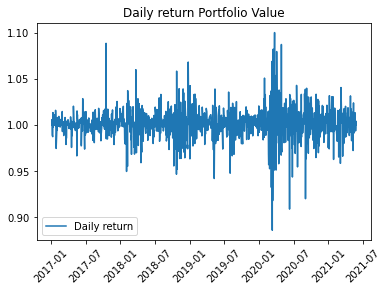

In [14]:
# A chart of daily return ratio over time
plt.plot(data.index,daily_r,label='Daily return')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Daily return Portfolio Value')

In [15]:
daily_r = pd.DataFrame(daily_r,index = data.index,columns=['daily return'])
# print(daily_r)
mean_daily = daily_r['daily return'].mean()
print("Average daily rate of return:",mean_daily)
mean_return_annualized = mean_daily**252 - 1
print("Annualized mean return ：", mean_return_annualized)

Average daily rate of return: 1.0009503487567801
Annualized mean return ： 0.27045380097551197


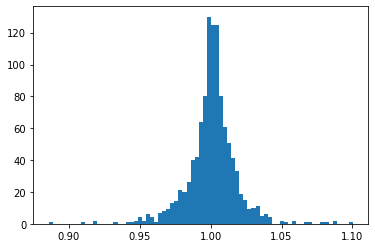

In [16]:
# A histogram of returns
plt.hist(np.array(daily_r), bins=75)
plt.show()

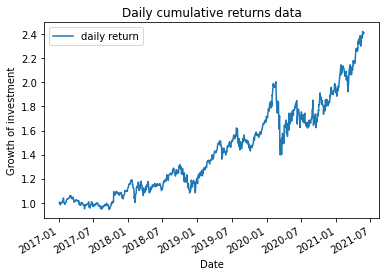

In [17]:
# This chart shows the cumulative returns since 2015 for four datasets.
cum_returns = daily_r.cumprod()
cum_returns.plot()
plt.xlabel("Date")
plt.ylabel("Growth of investment")
plt.title("Daily cumulative returns data")
plt.show()

In [18]:
std_daily = np.std(np.array(daily_r))
# print("Daily rate return standard deviation: ", std_daily)
variance_daily = std_daily ** 2
# print("Daily rate return variance: ", variance_daily)
std_annualized = std_daily*np.sqrt(252)
# print("Annualized standard deviation：", std_annualized)
variance_annualized = std_annualized ** 2
# print("Annualized variance：", variance_annualized)

In [19]:
volatility = std_daily * np.sqrt(252)
print("Volatility is: ",volatility)
SR = mean_daily/std_daily
print("Daily Sharpe ratio is: ",SR)
ASR=np.sqrt(252)*SR
# print("Annualized Sharpe ratio is: ",ASR)

Volatility is:  0.27861563482452484
Daily Sharpe ratio is:  57.030518747486305


In [20]:
# Max Drawdown
maximum = np.maximum.accumulate(np.array(daily_r))
MDD = ((maximum - np.array(daily_r)) / maximum).max()
print("Max Drawdown is: ",MDD)
CS = mean_return_annualized/MDD
print("Calmar Ratio is: ",CS)
win_rate = np.sum(np.array(daily_r)>=1) / np.array(daily_r).size
print("Winning days rate: ",win_rate)


Max Drawdown is:  0.1863977663953689
Calmar Ratio is:  1.4509497951914914
Winning days rate:  0.5645889792231256


In [25]:
eps = np.arange(0.8,1.2,0.02) 
C=500

cum_ret=np.ones(20) # Initialization
bah=np.ones(20) # Initialization
bcrp=np.ones(20) # Initialization

gamma = 0.0001
b=np.ones(d)/d
daily_r=np.ones(N)
tc=0.0007
for r in range(20):
    epsilon = eps[r]
    for t in range(N-1):
        le = np.maximum(0,np.dot(x[t],b) - epsilon)
        denominator = np.sum((x[t] - np.mean(x[t]))**2)
#         tau = le / denominator                         # PAMR
        tau = np.minimum(C, le / denominator)          # PAMR-1
#         tau = le / (denominator + 0.5 / C)             # PAMR-2
        b = b-tau * (x[t] - np.mean(x[t])) 
        b = simplex_proj(b)
    #     tc = gamma/2 * (np.abs(((x[t+1]*b)/ (np.dot(x[t+1],b)))[1:] - b[1:])).sum()
        daily_r[t] = np.dot(x[t+1],b) #* (1-tc)
        cum_ret[r] = cum_ret[r] * daily_r[t] 
        bah[r] = BAH
        bcrp[r] = BCRP

#     print("Cumulative return:",cum_ret[r]) 
print("Cumulative return wwww:",cum_ret) 
print("Cumulative return bah:",bah) 
print("Cumulative return bcrp:",bah) 


Cumulative return wwww: [2.45562918 2.45366184 2.45094122 2.45930319 2.49544288 2.50847482
 2.47931007 2.33325866 2.16562305 2.19453836 2.63876049 2.4218138
 2.23927197 2.96388625 4.69797417 3.36779455 3.02762017 3.02762017
 3.02762017 3.02762017]
Cumulative return bah: [3.25445456 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456
 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456
 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456
 3.25445456 3.25445456]
Cumulative return bcrp: [3.25445456 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456
 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456
 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456 3.25445456
 3.25445456 3.25445456]


Text(0.5, 1.0, 'Daily return value with different Epsilon size')

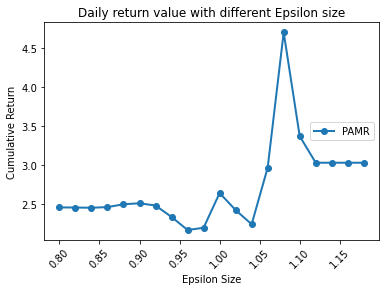

In [26]:
# A chart of daily return ratio over epsilon
plt.plot(eps,cum_ret,label='PAMR',linewidth=2,marker='o',markersize=6)
# plt.plot(eps,bah,label='Market',linewidth=2,marker='*',markersize=6)
# plt.plot(eps,bcrp,label='BCRP',linewidth=2,marker='+',markersize=6)

# plt.xticks(rotation=45)
# plt.xticks(np.arange(0,2,0.2))
plt.xticks(rotation=45)

plt.xlabel('Epsilon Size')
plt.ylabel('Cumulative Return')
plt.legend(loc=5)
plt.title('Daily return value with different Epsilon size')

In [23]:
eps = 0.5 
c=np.arange(0,5000,250)

cum_ret=np.ones(20) # Initialization
gamma = 0.0001
b=np.ones(d)/d
daily_r=np.ones(N)
tc=0.0007
for r in range(20):
    C = c[r]
    for t in range(N-1):
        le = np.maximum(0,np.dot(x[t],b) - epsilon)
        denominator = np.sum((x[t] - np.mean(x[t]))**2)
    #     tau = le / denominator                         # PAMR
    #     tau = np.minimum(C, le / denominator)          # PAMR-1
        tau = le / (denominator + 0.5 / C)             # PAMR-2
        b = b-tau * (x[t] - np.mean(x[t])) 
        b = simplex_proj(b)
    #     tc = gamma/2 * (np.abs(((x[t+1]*b)/ (np.dot(x[t+1],b)))[1:] - b[1:])).sum()
        daily_r[t] = np.dot(x[t+1],b) #* (1-tc)
        cum_ret[r] = cum_ret[r] * daily_r[t] 
#     print("Cumulative return:",cum_ret[r]) 
print("Cumulative return wwww:",cum_ret) 


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Cumulative return wwww: [2.97809629 2.97809629 2.97809629 2.97809629 2.97809629 2.97809629
 2.97809629 2.97809629 2.97809629 2.97809629 2.97809629 2.97809629
 2.97809629 2.97809629 2.97809629 2.97809629 2.97809629 2.97809629
 2.97809629 2.97809629]


Text(0.5, 1.0, 'Daily return value with different Epsilon size')

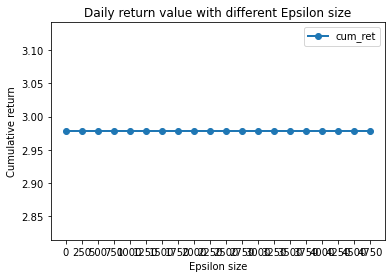

In [24]:
# A chart of daily return ratio over epsilon
plt.plot(c,cum_ret,label='cum_ret',linewidth=2,marker='o',markersize=6)
# plt.xticks(rotation=45)
plt.xticks(np.arange(0,5000,250))
plt.xlabel('Epsilon size')
plt.ylabel('Cumulative return')
plt.legend(loc='best')
plt.title('Daily return value with different Epsilon size')